In [1]:
! unzip conll2003.z

unzip:  cannot find or open conll2003.z, conll2003.z.zip or conll2003.z.ZIP.


In [2]:
import nltk
from nltk.corpus import stopwords
nltk.data.path.append("/opt/share/DAOzerova/nlp/")
russian_stopwords = stopwords.words('russian')

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

from nltk.corpus import stopwords
stop_words = stopwords.words('russian')

from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification
from transformers import DataCollatorForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer
from peft import LoraConfig, TaskType
from peft import get_peft_model

import pandas as pd
import numpy as np
import datasets
from datasets import load_metric 
from datasets import Dataset, DatasetDict
import csv

In [3]:
def prepare_df(df, labels_dct, map_func, split_func):
    df['sentence'] = np.where(df[0].shift(1) == '.', df[0].index, np.NaN)
    df = df.fillna(method='ffill').fillna(0.0)
    df['sentence'] = df[[0, 1, 'sentence']].groupby(['sentence'])[0].transform(lambda x: ' '.join(x))
    df['sentence_tags'] = df[[0, 1, 'sentence']].groupby(['sentence'])[1].transform(lambda x: ','.join(x))
    #df['ner_tags'] = df['sentence_tags'].apply(map_tags)

    df = df[['sentence', 'sentence_tags']].drop_duplicates(ignore_index=True)
    df['id'] = df.index 
    df['tokens'] = df['sentence'].apply(split_func)
    df['ner_tags'] = df['sentence_tags'].apply(map_func)
    
    return df

def create_HF_dataset(df_train, df_valid, df_test):
    #labels = df_train[1].value_counts().index.tolist()
    #labels_dct = {num: tag for tag, num in enumerate(labels)}
    labels_dct = {'O': 0, 
              'B-PER': 1,
              'I-PER': 2, 
              'B-ORG': 3, 
              'I-ORG': 4, 
              'B-LOC': 5, 
              'I-LOC': 6, 
              'B-MISC': 7, 
              'I-MISC': 8}
    
    def map_tags(row):
        return [labels_dct[x] for x in row.split(',')]
    
    def split_sentence(row, split_symb=' '):
        return row.split(split_symb)
    
    df_train = prepare_df(df_train, labels_dct, map_tags, split_sentence).iloc[:, 2:]
    df_valid = prepare_df(df_valid, labels_dct, map_tags, split_sentence).iloc[:, 2:]
    df_test = prepare_df(df_test, labels_dct, map_tags, split_sentence).iloc[:, 2:]
    
    df_train = Dataset.from_pandas(df_train)
    df_valid = Dataset.from_pandas(df_valid)
    df_test = Dataset.from_pandas(df_test)
    
    dataset = DatasetDict({
        'train': df_train,
        'validation': df_valid,
        'test': df_test
    })
    
    return dataset

def compute_metrics(logits_and_labels):
    logits, labels = logits_and_labels 
    predictions = np.argmax(logits, axis=-1)

    str_labels = [
        [label_names[t] for t in label if t!=-100] for label in labels
    ]

    str_preds = [
        [label_names[p] for (p, t) in zip(prediction, label) if t != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=str_preds, references=str_labels)

    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"], 
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]  
    } 

In [4]:
df_train = pd.read_csv('conll2003/train.tsv', sep='\t', header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')
df_valid = pd.read_csv('conll2003/valid.tsv', sep='\t', header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')
df_test = pd.read_csv('conll2003/test.tsv', sep='\t', header=None, quoting=csv.QUOTE_NONE, encoding='utf-8')
df_train.head()

,0,1
0,EU,B-ORG
1,rejects,O
2,German,B-MISC
3,call,O
4,to,O


## Эксплоративный анализ ##

In [5]:
analysis_df = pd.concat([df_train, df_valid, df_test], ignore_index=True)
analysis_df.head()

,0,1
0,EU,B-ORG
1,rejects,O
2,German,B-MISC
3,call,O
4,to,O


In [6]:
label_names = analysis_df[1].value_counts().index.tolist()
label_names

['O', 'B-LOC', 'B-PER', 'B-ORG', 'I-PER', 'I-ORG', 'B-MISC', 'I-MISC', 'I-LOC']

### Target distribution ###

In [7]:
print("Number of tags: {}".format(len(analysis_df[1].unique())))
frequencies = analysis_df[1].value_counts()
frequencies

Number of tags: 9


O         252050
B-LOC      10645
B-PER      10059
B-ORG       9323
I-PER       6991
I-ORG       5290
B-MISC      5062
I-MISC      1717
I-LOC       1671
Name: 1, dtype: int64

In [8]:
analysis_df['tag'] = analysis_df[1].apply(lambda x: x[2:5] if x != 'O' else x)
print("Number of tags: {}".format(len(analysis_df['tag'].unique())))
tag_frequencies = analysis_df['tag'].value_counts()
tag_frequencies

Number of tags: 5


O      252050
PER     17050
ORG     14613
LOC     12316
MIS      6779
Name: tag, dtype: int64

In [9]:
tag_frequencies.index.tolist()

['O', 'PER', 'ORG', 'LOC', 'MIS']

[]

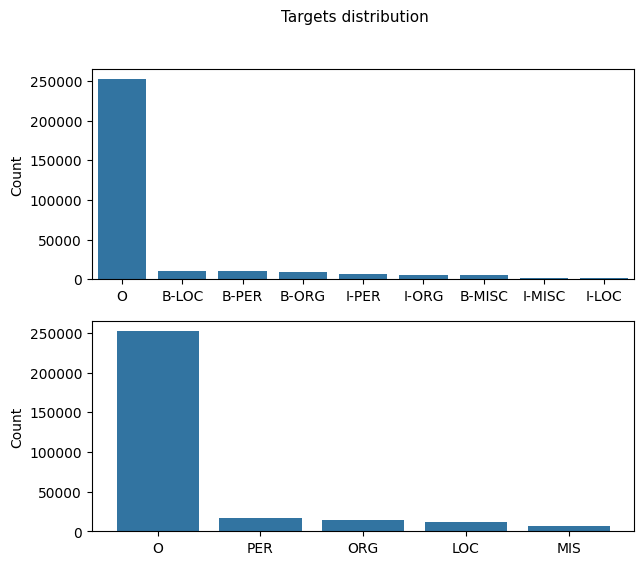

In [10]:
fig, ax = plt.subplots(2, figsize=(7, 6))
sns.barplot(frequencies, ax = ax[0])
sns.barplot(tag_frequencies, ax = ax[1])
ax[0].set_ylabel('Count')
ax[1].set_ylabel('Count')
fig.suptitle('Targets distribution', fontsize=11)
plt.plot()

In [11]:
tags = {}
for tag, count in zip(frequencies.index, frequencies):
    if tag != "O":
        if tag[2:5] not in tags.keys():
            tags[tag[2:5]] = count
        else:
            tags[tag[2:5]] += count

print(sorted(tags.items(), key=lambda x: x[1], reverse=True))

[('PER', 17050), ('ORG', 14613), ('LOC', 12316), ('MIS', 6779)]


### Top-10 frequency for each tag ###

In [12]:
concat_freqs = []
for i in tag_frequencies.index:
    concat_freqs.append(pd.Series(analysis_df[analysis_df['tag'] == i][0].value_counts()[:10].index))
pd.concat(concat_freqs, axis = 1).rename(columns={i: tag_frequencies.index.tolist()[i] for i in range(len(concat_freqs))})

,O,PER,ORG,LOC,MIS
0,.,Clinton,of,U.S.,Cup
1,",",Michael,Reuters,Germany,World
2,the,Mark,Newsroom,Australia,Russian
3,of,David,National,France,German
4,to,Yeltsin,United,England,British
5,in,John,Inc,Russia,European
6,a,Paul,New,Britain,French
7,(,Arafat,U.N.,Italy,Open
8,),Lebed,Party,China,Iraqi
9,and,M.,St,LONDON,American


### Word cloud with tags ###

CPU times: user 4.21 s, sys: 215 ms, total: 4.42 s
Wall time: 4.42 s


(-0.5, 2047.5, 2047.5, -0.5)

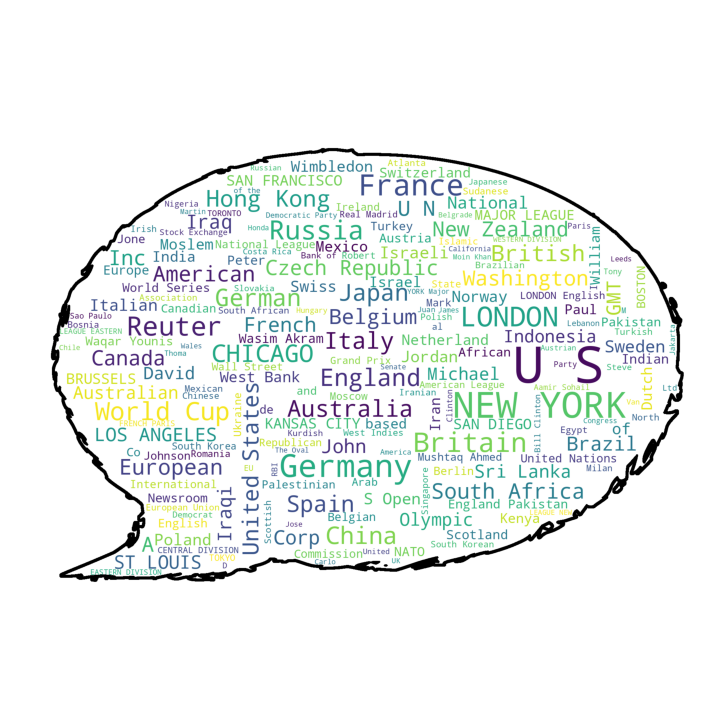

In [13]:
%%time

text = ' '.join(analysis_df[analysis_df[1] != 'O'][0].astype(str))

cloud_mask = np.array(Image.open('/opt/share/DAOzerova/nlp/TB/comment.png'))
cloud = WordCloud(background_color='white', max_font_size = 150, stopwords=stop_words, contour_width=10, mask=cloud_mask).generate(text)

plt.figure(figsize=(12, 9))
plt.imshow(cloud)
plt.axis('off')

In [14]:
labels = df_train[1].value_counts().index.tolist()
labels_dct = {num: tag for tag, num in enumerate(labels)}
def map_tags(row):
    return [labels_dct[x] for x in row.split(',')]

def split_sentence(row, split_symb=' '):
    return row.split(split_symb)

analysis_df = prepare_df(analysis_df, labels_dct, map_tags, split_sentence)
analysis_df.head()

,sentence,sentence_tags,id,tokens,ner_tags
0,EU rejects German call to boycott British lamb .,"B-ORG,O,B-MISC,O,O,O,B-MISC,O,O",0,"[EU, rejects, German, call, to, boycott, Briti...","[3, 0, 6, 0, 0, 0, 6, 0, 0]"
1,Peter Blackburn BRUSSELS 1996-08-22 The Europe...,"B-PER,I-PER,B-LOC,O,O,B-ORG,I-ORG,O,O,O,O,O,O,...",1,"[Peter, Blackburn, BRUSSELS, 1996-08-22, The, ...","[2, 4, 1, 0, 0, 3, 5, 0, 0, 0, 0, 0, 0, 6, 0, ..."
2,Germany 's representative to the European Unio...,"B-LOC,O,O,O,O,B-ORG,I-ORG,O,O,O,B-PER,I-PER,O,...",2,"[Germany, 's, representative, to, the, Europea...","[1, 0, 0, 0, 0, 3, 5, 0, 0, 0, 2, 4, 0, 0, 0, ..."
3,""" We do n't support any such recommendation be...","O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,...",3,"["", We, do, n't, support, any, such, recommend...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,He said further scientific study was required ...,"O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-...",4,"[He, said, further, scientific, study, was, re...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


[]

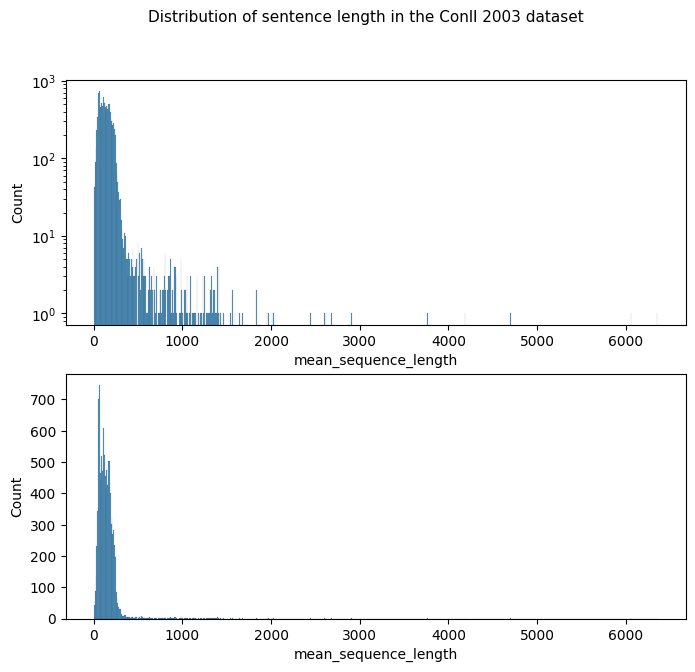

In [15]:
analysis_df['mean_sequence_length'] = analysis_df['sentence'].apply(len)
fig, ax = plt.subplots(2, figsize=(8, 7))
sns.histplot(analysis_df['mean_sequence_length'], log=True, ax = ax[0])
sns.histplot(analysis_df['mean_sequence_length'], ax = ax[1])
fig.suptitle('Distribution of sentence length in the Conll 2003 dataset', fontsize=11)
plt.plot()

### Prepare dataset ###

In [16]:
#{'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}

In [17]:
labels = df_train[1].value_counts().index.tolist()
labels_dct = {num: tag for tag, num in enumerate(labels)}
def map_tags(row):
    return [labels_dct[x] for x in row.split(',')]

def split_sentence(row, split_symb=' '):
    return row.split(split_symb)
    
ddf = prepare_df(df_train, labels_dct, map_tags, split_sentence)#.head() #.iloc[:, 1:]
ddf.iloc[415]

sentence         * ( Note - contents are displayed in reverse o...
sentence_tags    O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,B-ORG,O,O,O,O,B-...
id                                                             415
tokens           [*, (, Note, -, contents, are, displayed, in, ...
ner_tags         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 415, dtype: object

In [18]:
dataset = create_HF_dataset(df_train, df_valid, df_test)
dataset['train'][0]

{'id': 0,
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0]}

## BERT Fine-tuning ##

In [19]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [20]:
token = tokenizer(dataset['train'][0]['tokens'], is_split_into_words = True)

# Print the tokenizer object, the tokenized tokens, and the word IDs
print(token, '\n\n', 
      token.tokens(),'\n\n',
      token.word_ids())

{'input_ids': [101, 7270, 22961, 1528, 1840, 1106, 21423, 1418, 2495, 12913, 119, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]} 

 ['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]'] 

 [None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None]


In [21]:
def align_target(labels, word_ids):
    begin2inside = {
        1: 2,  # B-LOC -> I-LOC
        3: 4,  # B-MISC -> I-MISC
        5: 6,  # B-ORG -> I-ORG
        7: 8    # B-PER -> I-PER
    }

    align_labels = []
    last_word = None

    for word in word_ids:
        if word is None:
            label = -100  # Set label to -100 for None word_ids
        elif word != last_word:
            try:
                label = labels[word]  # Use the label corresponding to the current word_id
            except:
                print('LEN', len(labels), len(word_ids), word)
        else:
            try:
                label = labels[word]
            except:
                print('LAST WORD',  len(labels), len(word_ids), word)
            if label in begin2inside:
                label = begin2inside[label]  # Map B- to I-

        align_labels.append(label)
        last_word = word

    return align_labels

In [22]:
labels = dataset['train'][0]['ner_tags']
word_ids = token.word_ids()

aligned_target = align_target(labels, word_ids)

print(token.tokens(), '\n\n',
      token.word_ids(), '\n\n',
      labels, '\n\n',
      aligned_target)

['[CLS]', 'EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'la', '##mb', '.', '[SEP]'] 

 [None, 0, 1, 2, 3, 4, 5, 6, 7, 7, 8, None] 

 [3, 0, 7, 0, 0, 0, 7, 0, 0] 

 [-100, 3, 0, 7, 0, 0, 0, 7, 0, 0, 0, -100]


In [23]:
aligned_labels = [label_names[t] if t >= 0 else None for t in aligned_target]

for x, y in zip(token.tokens(), aligned_labels):
    print(f"{x}\t{y}")

[CLS]	None
EU	B-ORG
rejects	O
German	I-MISC
call	O
to	O
boycott	O
British	I-MISC
la	O
##mb	O
.	O
[SEP]	None


In [24]:
words = ['[CLS]', 'Ger', '##man', 'call', 'to', 'Micro', '##so', '##ft', '[SEP]']
word_ids = [None, 0, 0, 1, 2, 3, 3, 3, None]
labels = [7, 0, 0, 3, 4]

aligned_target = align_target(labels, word_ids)

aligned_labels = [label_names[t] if t >= 0 else None for t in aligned_target]
for x, y in zip(words, aligned_labels):
    print(f"{x}\t{y}")

[CLS]	None
Ger	I-MISC
##man	I-LOC
call	O
to	O
Micro	B-ORG
##so	I-PER
##ft	I-PER
[SEP]	None


In [25]:
def tokenize_fn(batch):
    tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)
    labels_batch = batch['ner_tags']
    aligned_targets_batch = []

    for i, labels in enumerate(labels_batch):
        word_ids = tokenized_inputs.word_ids(i)
        #print(len(labels), len(word_ids))
        #print(align_target(labels, word_ids))
        aligned_targets_batch.append(align_target(labels, word_ids))

    tokenized_inputs["labels"] = aligned_targets_batch
    return tokenized_inputs

In [26]:
#tokenizer(dataset['train'][415]['tokens'], is_split_into_words = True).word_ids()

In [27]:
#tokenizer(dataset['train'][415]['tokens'], is_split_into_words = True).tokens()

In [28]:
#dataset['train'][415]['tokens']

In [29]:
tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=dataset['train'].column_names)

Map:   0%|          | 0/7289 [00:00<?, ? examples/s]

Map:   0%|          | 0/1868 [00:00<?, ? examples/s]

Map:   0%|          | 0/1611 [00:00<?, ? examples/s]

In [30]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
batch = data_collator([tokenized_dataset['train'][i] for i in range(2)])
batch

{'input_ids': tensor([[  101,  7270, 22961,  1528,  1840,  1106, 21423,  1418,  2495, 12913,
           119,   102,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0],
        [  101,  1943, 14428, 26660, 13329, 12649, 15928,  1820,   118,  4775,
           118,  1659,  1109,  1735,  2827,  1163,  1113,  9170,  1122, 19786,
          1114,  1528,  5566,  1106, 11060,  1106,   188, 17315,  1418,  2495,
         12913,  1235,  6479,  4959,  2480,  6340, 13991,  3653,  1169,  1129,
         12086,  1106,  8892,   119,   102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         

In [31]:
metric = load_metric("seqeval")
metric.compute(predictions = [['O' , 'B-ORG' , 'I-ORG']], 
               references = [['O' , 'B-MISC' , 'I-ORG']])

/tmp/ipykernel_1300440/1842672277.py:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")
/home/daozerova/.conda/envs/fl_test/lib/python3.9/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'MISC': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'ORG': {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'number': 1},
 'overall_precision': 0.0,
 'overall_recall': 0.0,
 'overall_f1': 0.0,
 'overall_accuracy': 0.6666666666666666}

In [33]:
id2label = {k: v for k, v in enumerate(label_names)} 
label2id = {v: k for k, v in enumerate(label_names)}

print(id2label , '\n\n' , label2id)

{0: 'O', 1: 'B-LOC', 2: 'B-PER', 3: 'B-ORG', 4: 'I-PER', 5: 'I-ORG', 6: 'B-MISC', 7: 'I-MISC', 8: 'I-LOC'} 

 {'O': 0, 'B-LOC': 1, 'B-PER': 2, 'B-ORG': 3, 'I-PER': 4, 'I-ORG': 5, 'B-MISC': 6, 'I-MISC': 7, 'I-LOC': 8}


In [34]:
model = AutoModelForTokenClassification.from_pretrained(
  checkpoint,
  id2label=id2label,  
  label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
training_args = TrainingArguments( 
    output_dir = "fine_tuned_model",
    evaluation_strategy = "epoch",
    learning_rate = 2e-5, 
    
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,

    num_train_epochs = 3,
    weight_decay = 0.01
)

/home/daozerova/.conda/envs/fl_test/lib/python3.9/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [36]:
trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator 
)

In [37]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,0.101158,0.904943,0.890342,0.897583,0.963185
2,0.244700,0.079149,0.913198,0.924371,0.918750,0.972393
3,0.083000,0.074282,0.924534,0.929342,0.926932,0.976585


TrainOutput(global_step=1368, training_loss=0.13451083780032153, metrics={'train_runtime': 85.9324, 'train_samples_per_second': 254.468, 'train_steps_per_second': 15.919, 'total_flos': 806061174829848.0, 'train_loss': 0.13451083780032153, 'epoch': 3.0})

In [38]:
trainer.evaluate()

{'eval_loss': 0.07428178936243057,
 'eval_precision': 0.9245340433624952,
 'eval_recall': 0.9293415921082817,
 'eval_f1': 0.9269315841659675,
 'eval_accuracy': 0.9765847231787286,
 'eval_runtime': 2.6754,
 'eval_samples_per_second': 698.221,
 'eval_steps_per_second': 43.732,
 'epoch': 3.0}

In [39]:
trainer.predict(tokenized_dataset["test"]).metrics

{'test_loss': 0.12509502470493317,
 'test_precision': 0.8867807635715945,
 'test_recall': 0.9025063051702396,
 'test_f1': 0.8945744306863013,
 'test_accuracy': 0.9590341408309275,
 'test_runtime': 2.8145,
 'test_samples_per_second': 572.391,
 'test_steps_per_second': 35.885}

In [40]:
trainer.save_model('fine_tuned_model')

In [41]:
#' '.join(dataset['test']['tokens'][100])

### PEFT ###

In [42]:
model = AutoModelForTokenClassification.from_pretrained(
  'distilbert-base-cased',
  id2label=id2label,  
  label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [43]:
model

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [44]:
peft_config = LoraConfig(task_type=TaskType.SEQ_CLS,\
              inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1, \
              target_modules='all-linear')

In [45]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

/home/daozerova/.conda/envs/fl_test/lib/python3.9/site-packages/bitsandbytes/cuda_setup/main.py:166: UserWarning: Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes


  warn(msg)


False

===================================BUG REPORT===================================
The following directories listed in your path were found to be non-existent: {PosixPath('/user/daozerova/oauth_callback')}
The following directories listed in your path were found to be non-existent: {PosixPath('servers!server=daozerova/", "access'), PosixPath('["access'), PosixPath('servers!user=daozerova"]')}
The following directories listed in your path were found to be non-existent: {PosixPath('servers!server=daozerova/", "access'), PosixPath('["access'), PosixPath('servers!user=daozerova"]')}
The following directories listed in your path were found to be non-existent: {PosixPath('8081/hub/api'), PosixPath('//127.0.0.1'), PosixPath('http')}
The following directories listed in your path were found to be non-existent: {PosixPath('//127.0.0.1'), PosixPath('8081/hub/api/users/daozerova/activity'), PosixPath('http')}
The following directories listed in your path were found to be non-existent: {PosixP

RuntimeError: 
        CUDA Setup failed despite GPU being available. Please run the following command to get more information:

        python -m bitsandbytes

        Inspect the output of the command and see if you can locate CUDA libraries. You might need to add them
        to your LD_LIBRARY_PATH. If you suspect a bug, please take the information from python -m bitsandbytes
        and open an issue at: https://github.com/TimDettmers/bitsandbytes/issues

In [ ]:
training_args = TrainingArguments( 
    output_dir = "peft_tuned_model",
    evaluation_strategy = "epoch",
    learning_rate = 2e-5, 
    
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 16,

    num_train_epochs = 3,
    weight_decay = 0.01,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model, 
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator 
)

trainer.train()

In [ ]:
trainer.evaluate()

In [ ]:
trainer.predict(tokenized_dataset["test"]).metrics